In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql.functions import col, udf, array_join
import pyspark.sql.functions as F

from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Predict Air pollution according to the weather

# Step 1: Reading data from MongoDB

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Создание Spark сессии
spark = SparkSession.builder \
    .appName("MongoDBIntegration") \
    .config("spark.mongodb.read.connection.uri", "mongodb://mongodb:27017") \
    .config("spark.mongodb.write.connection.uri", "mongodb://mongodb:27017") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.mongodb.read.database", "wether_db") \
    .getOrCreate()

# Чтение данных из коллекций
weather_df = spark.read \
    .format("mongo") \
    .option("uri", "mongodb://mongodb:27017/wether_db.weather") \
    .load()

quality_df = spark.read \
    .format("mongo") \
    .option("uri", "mongodb://mongodb:27017/wether_db.quality") \
    .load()

quality_df = quality_df.withColumnRenamed("timestamp", "timestamp_quality")

# Показ первых 5 строк
print("Weather DataFrame:")
weather_df.show(5)

print("Quality DataFrame:")
quality_df.show(5)

print("Merged DataFrame:")
spark_merged_df = weather_df.join(quality_df, weather_df.timestamp == quality_df.timestamp_quality, "inner")
spark_merged_df = spark_merged_df.select('precipitation','relative_humidity_2m','temperature_2m','timestamp','wind_speed_10m',\
                                         'aqi','co','nh3','no','no2','o3','pm10','pm2_5','so2')
spark_merged_df = spark_merged_df.withColumn("timestamp", (col("timestamp") / 1000).cast(IntegerType()))
spark_merged_df = spark_merged_df.na.drop()
spark_merged_df.show(5)

Weather DataFrame:
+--------------------+-------------+-------------+--------------------+--------------+-------------+--------------+
|                 _id|           id|precipitation|relative_humidity_2m|temperature_2m|    timestamp|wind_speed_10m|
+--------------------+-------------+-------------+--------------------+--------------+-------------+--------------+
|{667be4ecc49c64eb...|1640995200000|          0.0|       91.1875305176| -1.4955000877|1640995200000| 15.7456274033|
|{667be4ecc49c64eb...|1640998800000|          0.0|       91.1840362549| -1.5455000401|1640998800000| 15.2819890976|
|{667be4ecc49c64eb...|1641002400000|          0.0|       90.8389816284| -1.6455000639|1641002400000| 15.9460096359|
|{667be4ecc49c64eb...|1641006000000|          0.0|       89.7953338623| -2.0954999924|1641006000000| 14.4897203445|
|{667be4ecc49c64eb...|1641009600000|          0.0|       91.1314086914| -2.2955000401|1641009600000| 12.4811534882|
+--------------------+-------------+-------------+---

# Step 2: Prediction

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Prepare features and labels
assembler = VectorAssembler(
    inputCols=["temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m"],
    outputCol="features"
)

data = assembler.transform(spark_merged_df)
data = data.select("timestamp", "features", F.col("pm2_5").alias("label"))

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train a Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")

# Show some predictions with timestamps
predictions.select("timestamp", "label", "prediction")\
.orderBy("timestamp", ascending=False)\
.show(10)


Root Mean Squared Error (RMSE): 5.579928721893552
R2: 0.1377952483797248
+----------+-----+------------------+
| timestamp|label|        prediction|
+----------+-----+------------------+
|1718838000|  2.5|3.2357557178125966|
|1718780400| 2.79|3.4590229347817494|
|1718748000| 3.64|3.3952521801760156|
|1718726400|13.44| 4.588401877777718|
|1718708400|  3.2| 5.147811036222825|
|1718690400| 2.74| 5.186092782301443|
|1718676000| 1.56|  8.85894752099012|
|1718672400| 1.39| 7.965449363425355|
|1718647200| 1.67| 9.672649801596743|
|1718640000| 1.53|  9.36668344019158|
+----------+-----+------------------+
only showing top 10 rows



# Step 3: Analyze and Visualize Results
## Use Matplotlib for visualization.

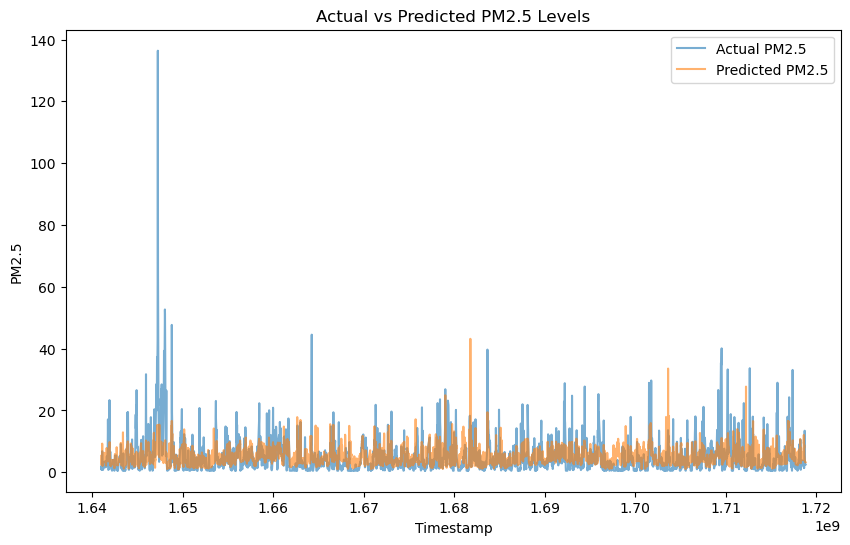

In [11]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for visualization
predictions_pd = predictions.select("timestamp", "label", "prediction").toPandas()

# Plot actual vs predicted PM2.5 levels
plt.figure(figsize=(10, 6))
plt.plot(predictions_pd['timestamp'], predictions_pd['label'], label='Actual PM2.5', alpha=0.6)
plt.plot(predictions_pd['timestamp'], predictions_pd['prediction'], label='Predicted PM2.5', alpha=0.6)
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 Levels')
plt.legend()
plt.show()

# Step 4: Feature Engineering
## Let's create additional features and include them in the model:

In [12]:
from pyspark.sql.functions import year, month, dayofmonth, hour, from_unixtime
from pyspark.ml.feature import VectorAssembler

# Add new time-based features
spark_merged_df  = spark_merged_df.withColumn('timestamp', from_unixtime('timestamp'))
spark_merged_df = spark_merged_df.withColumn('year', year('timestamp'))
spark_merged_df = spark_merged_df.withColumn('month', month('timestamp'))
spark_merged_df = spark_merged_df.withColumn('day', dayofmonth('timestamp'))
spark_merged_df = spark_merged_df.withColumn('hour', hour('timestamp'))

# Prepare features and labels
assembler = VectorAssembler(
    inputCols=[
        "temperature_2m", 
        "relative_humidity_2m", 
        "precipitation", 
        "wind_speed_10m",
        "year",
        "month",
        "day",
        "hour"
    ],
    outputCol="features"
)

data = assembler.transform(spark_merged_df)
data = data.select("timestamp", "features", F.col("pm2_5").alias("label"))

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Step 5.1: Train a Random Forest Regressor

## Manually tune hyperparameters and train the model.

In [13]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)

# Train the model
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")

# Show some predictions with timestamps
rf_predictions.select("timestamp", "label", "prediction").show(10)

Root Mean Squared Error (RMSE): 4.112419514969822
R2: 0.5316743634420884
+-------------------+-----+------------------+
|          timestamp|label|        prediction|
+-------------------+-----+------------------+
|2022-01-01 02:00:00| 1.87| 2.758242610058458|
|2022-01-01 06:00:00| 1.01| 2.018924347870111|
|2022-01-01 08:00:00|  0.9|  1.96558520886294|
|2022-01-01 13:00:00| 0.92|1.3339437145400712|
|2022-01-01 19:00:00|  1.0|1.5120821970358689|
|2022-01-01 23:00:00| 0.78|1.9028469511648132|
|2022-01-02 05:00:00| 2.49| 2.952344886191759|
|2022-01-02 11:00:00| 6.81| 7.382207052878015|
|2022-01-02 21:00:00| 2.85| 2.055579678657355|
|2022-01-02 22:00:00| 2.65|1.8954380873337917|
+-------------------+-----+------------------+
only showing top 10 rows



# Step 5.2: Train a Gradient Boosting Regressor

## Manually tune hyperparameters and train the model.

In [18]:
from pyspark.ml.regression import GBTRegressor

# Initialize the Gradient Boosting Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=10)

# Train the model
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
rmse = evaluator.evaluate(gbt_predictions)
r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")

# Show some predictions with timestamps
gbt_predictions.select("timestamp", "label", "prediction").show(10)

Root Mean Squared Error (RMSE): 3.4025218811115585
R2: 0.6794063154115852
+-------------------+-----+--------------------+
|          timestamp|label|          prediction|
+-------------------+-----+--------------------+
|2022-01-01 02:00:00| 1.87|   2.049867159976154|
|2022-01-01 06:00:00| 1.01| 0.37684072432517224|
|2022-01-01 08:00:00|  0.9| 0.20688579985750236|
|2022-01-01 13:00:00| 0.92|  1.1715959464626469|
|2022-01-01 19:00:00|  1.0|  1.2493537290673995|
|2022-01-01 23:00:00| 0.78|  0.9989145085785215|
|2022-01-02 05:00:00| 2.49|   2.481215084920383|
|2022-01-02 11:00:00| 6.81|   8.604171578325996|
|2022-01-02 21:00:00| 2.85|-0.24392717461120192|
|2022-01-02 22:00:00| 2.65|-0.05295600358620...|
+-------------------+-----+--------------------+
only showing top 10 rows



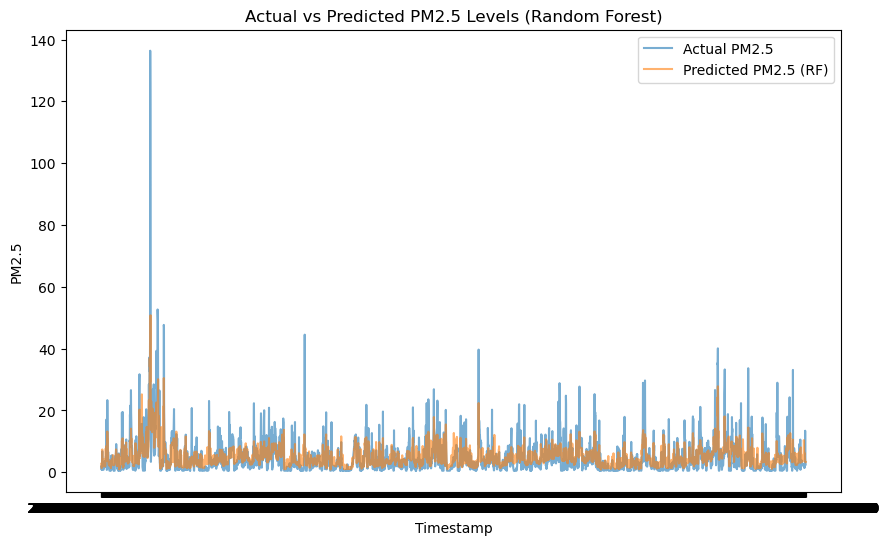

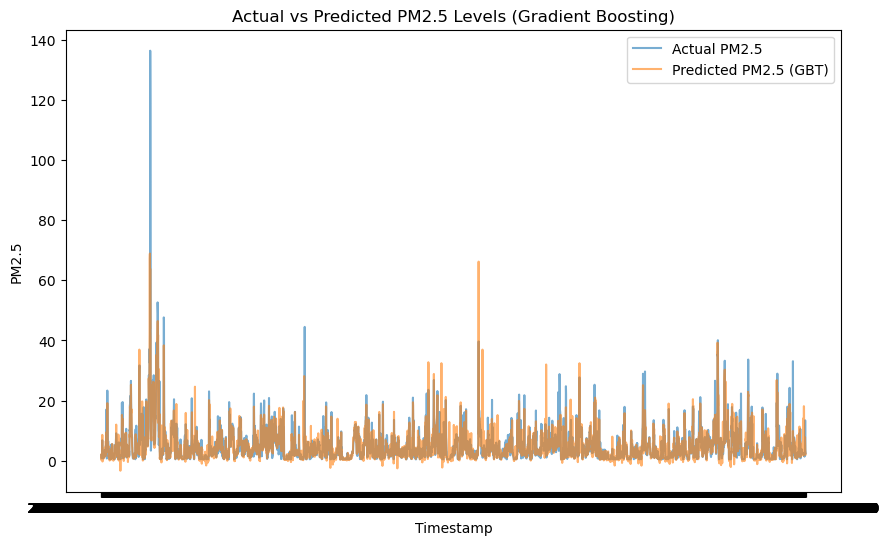

In [19]:
# Convert to Pandas DataFrame for visualization
rf_predictions_pd = rf_predictions.select("timestamp", "label", "prediction").toPandas()
gbt_predictions_pd = gbt_predictions.select("timestamp", "label", "prediction").toPandas()

# Plot actual vs predicted PM2.5 levels for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(rf_predictions_pd['timestamp'], rf_predictions_pd['label'], label='Actual PM2.5', alpha=0.6)
plt.plot(rf_predictions_pd['timestamp'], rf_predictions_pd['prediction'], label='Predicted PM2.5 (RF)', alpha=0.6)
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 Levels (Random Forest)')
plt.legend()
plt.show()

# Plot actual vs predicted PM2.5 levels for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.plot(gbt_predictions_pd['timestamp'], gbt_predictions_pd['label'], label='Actual PM2.5', alpha=0.6)
plt.plot(gbt_predictions_pd['timestamp'], gbt_predictions_pd['prediction'], label='Predicted PM2.5 (GBT)', alpha=0.6)
plt.xlabel('Timestamp')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 Levels (Gradient Boosting)')
plt.legend()
plt.show()
